# Reinforcement learning Assignment 1:
## Simulation study of UCB and Thompon sampling  
### by Buelent Uendes

In this assignment, I will replicate Figure 1 of the article Chapelle and Li (2011).

# Part 1: Pre-Work

## Importing necessary libraries 

In [1]:
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from IPython.display import Image
from collections import defaultdict

In [2]:
random.seed(10)

## Defining functions and classes I need for this assignment 

### Simulating the data 

In [3]:
def simulate_data(K, eps, T,p_best):
    p = [p_best] + [p_best - eps]*(K-1)
    data = {}
    for i in range(0,K):
        sample = [np.random.binomial(1,p[i]) for j in range(0, T)]
        data[i] = sample
    return pd.DataFrame(data)

### Asymptotic regret 

The KL divergence between two bernoulli distribution can be calculated as follows, where q denotes p* in our case:

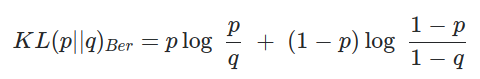

In [4]:
Image(filename='KL_divergence_Bernoulli.png', width = 400, height = 400) 

Moreover, the asymptotic regret can be calculated as:

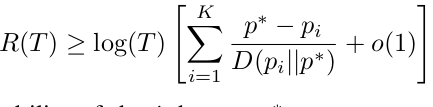

In [5]:
Image(filename= 'Asymptotic_regret.png', width = 300, height = 300)

We will drop the constant term for our simulation.

In [6]:
def asymptotic_regret(T, p_best, eps, K):
    p = [p_best] + [p_best - eps]*(K-1)
    divergence_sum = 0
    for i in range(0,len(p)):
        if p[i] != p_best: #log(0) is not defined, so we need to exclude this!
            divergence_sum += (p_best-p[i])/(p[i]*np.log(p[i]/p_best) + (1-p[i]) * np.log((1-p[i])/(1-p_best)))
    return np.log(T)*(divergence_sum)

In [7]:
def dataframe_asymptotic_regret(dataframe, T, p_best, eps, K):
    dataframe['Regret: {}, eps: {}'.format(K,eps)] = [asymptotic_regret(t, p_best, eps, K) for t in np.arange(1,T+1)]
    dataframe['t'] = x_values = [np.log10(t) for t in np.arange(1, T+1)]
    return dataframe

### UCB Sampler and Thompson sampler 

**Important note**

I implement the UCB algorithm based on the algorithm that was provided in class, i.e. the way the upper bound is calculated differes slightly. Yet, this should not qualitatively affect the results obtained in this assignment.

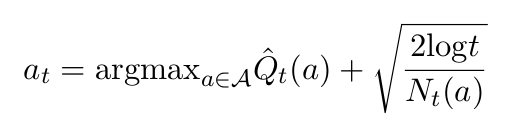

In [8]:
Image(filename='UCB_Auer.png', width = 350, height = 350) 

In [9]:
class ucb_sampling():
    def __init__(self,k, index_best_arm):
        self.number_of_selected_arms_ucb = [0] * k #Here we store how many times each arm was pulled 
        self.sum_rewards_ucb_arm = [0] * k #here we store total rewards for each arm
        self.arm_selected_ucb = [] #here we store what arm was eventually selected for each round
        self.total_rewards = 0 #beginning zero rewards
        self.total_regret = [] #also zero regret first trial
        self.best_arm = index_best_arm
    def fit(self, N, dataset, k, p_best, eps):
        for n in range(0,N):
            arm = 0
            max_upper_bound = 0
            regret = 0
            for i in range(0,k):
                if self.number_of_selected_arms_ucb[i] == 0:
                    max_upper_bound_proposed = 100e10 #Very high number to force to pull all levers
                else:
                    m = self.number_of_selected_arms_ucb[i]
                    if m == 0:
                        print(m,i,n) #In case that m is negative, I want to see a warning! This should not be the case though!
                    avg_reward = self.sum_rewards_ucb_arm[i] / m #Take the average
                    bound = np.sqrt((2 * np.log(n))/ m)
                    max_upper_bound_proposed = avg_reward + bound
                if max_upper_bound_proposed > max_upper_bound:
                    max_upper_bound = max_upper_bound_proposed
                    arm = i
            if arm != self.best_arm:
                regret = eps
            if n == 0: #first round we do not need previous value as there is no value!
                self.total_regret.append(regret)
            else:
                self.total_regret.append(self.total_regret[n-1] + regret)
            self.number_of_selected_arms_ucb[arm] += 1
            self.arm_selected_ucb.append(arm)
            reward = dataset.values[n, arm]
            self.total_rewards += reward
            self.sum_rewards_ucb_arm[arm] += reward

In [10]:
class thompson_sampling():
    def __init__(self, k, index_best_arm):
        self.number_of_selected_arms_thompson = [0] * k #Here we store how many times each arm was pulled 
        self.sum_rewards_thompson_arm = [0] * k #here we store total rewards for each arm
        self.arm_selected_thompson = [] #here we store what arm was eventually selected for each round
        self.number_of_reward_0 = [0]*k
        self.number_of_reward_1 = [0]*k
        self.total_rewards = 0 #beginning zero rewards
        self.total_regret = [] #also zero regret first trial
        self.best_arm = index_best_arm
    def fit(self, N, dataset, k, p_best, eps, alpha, beta):
        for n in range(0,N):
            arm = 0
            max_value = 0
            regret = 0
            for i in range(0,k):
                max_value_proposed = np.random.beta(alpha+self.number_of_reward_1[i], beta + self.number_of_reward_0[i])
                if max_value_proposed > max_value:
                    max_value = max_value_proposed
                    arm = i
            if arm != self.best_arm:
                regret = eps
            else:
                regret = 0
            if n == 0: #First round we do not need previous value as there is no value!
                self.total_regret.append(regret)
            else:
                self.total_regret.append(self.total_regret[n-1] + regret)
            self.number_of_selected_arms_thompson[arm] += 1
            self.arm_selected_thompson.append(arm)
            reward = dataset.values[n, arm]
            if reward == 1:
                self.number_of_reward_1[arm] += 1
            else:
                self.number_of_reward_0[arm] += 1
            self.total_rewards = self.total_rewards + reward
            self.sum_rewards_thompson_arm[arm] += reward

# Part 2: Creating the dataset

After having defined the functions and classes we need for this assignment, I will create the dataset I need. 

**Important note!**

Given my computational constraint, I will only run the simulation for K = 10 and N 1000000, as otherwise my kernel dies. Yet, one could complete the other condition easily using my function and my classes (and of course with a better laptop/more computational power ;) )

In [11]:
# Set the parameters for the simulated data
K = [10,100]
eps = [0.1, 0.02]
p_best = 0.5
T_1 = 10000000 #for K 10
T_2 = 10000000 #for K 100

In [ ]:
sim_data_1 = simulate_data(K[0], eps[0], T_1, p_best)  #K = 10, eps = 0.1
#sim_data_2 = simulate_data(K[1], eps[0], T_2, p_best) #K = 100, eps = 0.1 #Uncomment to run as well
sim_data_3 = simulate_data(K[0], eps[1], T_1, p_best) #K = 10, eps  = 0.02 
#sim_data_4 = simulate_data(K[1], eps[1], T_2, p_best) #K = 100, eps  = 0.02 #Uncomment to run as well

# Simulation study

## Step 1:  Defining a simulator  

In [ ]:
class simulator():
    def __init__(self,N, sim_n, alpha = None, beta = None):
        self.N = N
        self.sim = sim_n
        self.alpha = alpha
        self.beta = beta
    def simulation(self, sampler, dataset, k, index_best_arm, p_best, eps): #We set standard values only if provided
        sampler_alg = sampler(k,index_best_arm)
        total_regret = [0] * self.N #We initialize the list
        for sim in range(0,self.sim):
            print("Please wait while the simulation runs! Iteration: {}".format(sim+1))
            if self.alpha != None: #Then we have the thompson sampler!
                sampler_alg.fit(self.N, dataset,k,p_best,eps,alpha = self.alpha, beta = self.beta)
            else:
                sampler_alg.fit(self.N, dataset,k,p_best,eps)
            result = sampler_alg.total_regret
            total_regret = [reg_old + reg_new for reg_old, reg_new in zip(total_regret, result)]
        total_regret = [element/self.sim for element in total_regret] #Return the average
        self.average_total_regret = total_regret
        print("The simulation is done!")
    def get_regret(self):
        return self.average_total_regret

## Step 2: Running the simulation 

### a) Thompson sampling 

In [ ]:
results = {}
data = [sim_data_1, sim_data_3]
alpha = beta = 1
for i in range(0,2):
    my_simulator = simulator(T_1,30, alpha, beta)
    my_simulator.simulation(thompson_sampling, data[i], K[0],0,0.5,eps[i])
    results['Thompson: K {} eps {}'.format(K[0], eps[i])] = my_simulator.get_regret()

### b) UCB sampling 

Now, we need to do the same for the UCB sampler!

In [ ]:
for i in range(0,2):
    my_simulator = simulator(T_1,30)
    my_simulator.simulation(ucb_sampling, data[i], K[0],0,0.5,eps[i])
    results['UCB: K {} eps {}'.format(K[0], eps[i])] = my_simulator.get_regret()

### Save my results in csv file 

Given that my simulation took so long, I will save my results in a csv file in the case that my kernel dies.

In [ ]:
df = pd.DataFrame.from_dict(results) 

In [ ]:
df.to_csv (r'gen.csv', index = False, header=True)

## Step 3: Asymptotic cumulative regret

In [ ]:
df = dataframe_asymptotic_regret(df, T_1, 0.5, eps[0], K[0])
results = dataframe_asymptotic_regret(df, T_1, 0.5, eps[1], K[0])

## Step 4: Plotting the results 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Empirical results simulation study', fontsize = 15)
ax1.plot(results.t, results['Regret: 10, eps: 0.1'])
ax1.plot(results.t, results['Thompson: K 10 eps 0.1'])
ax1.plot(results.t, results['UCB: K 10 eps 0.1'])
ax1.set_title('K = 10, eps = 0.1')
ax1.set_ylabel("Cumulative regret")
ax1.set_xlabel("trials (in log 10)")
ax1.legend(["Asymptotic lower bound" , "Thompson", "UCB"])

ax2.plot(results.t, results['Regret: 10, eps: 0.02'])
ax2.plot(results.t, results['Thompson: K 10 eps 0.02'])
ax2.plot(results.t, results['UCB: K 10 eps 0.02'])
ax2.legend(["Asymptotic lower bound" , "Thompson", "UCB"])
ax2.set_title('K = 10, eps = 0.02')
ax2.set_ylabel("Cumulative regret")
ax2.set_xlabel("trials (in log 10)")
